# XGBoost Regression Workflow Illustrated

This notebook demonstrates a simplified version of the main pipeline from your script:
- Preparing data (simulated here)
- Training an XGBoost regression model
- Evaluating performance
- Using SHAP to interpret the model

---

## 1. Setup and Imports

We import necessary libraries for data handling, modeling, evaluation, and visualization.

In [20]:
import argparse
import logging
from datetime import datetime
from pathlib import Path
import os
import re
import glob
import numpy as np
from osgeo import gdal
import errno
import fnmatch
import sys
import imageio
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import shap
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import RandomizedSearchCV
import rasterio

# Enable inline plotting for matplotlib
%matplotlib inline


parser = argparse.ArgumentParser(description='Process GeoTIFF data for XGboost machine learning.')

############# PARAMETERS FOR DATA DOWNLOADING ################
parser.add_argument('--static_api_url', type=str, default="https://terrabrasilis.dpi.inpe.br/stac-api/v1",
                    help='Data url')   
parser.add_argument('--time_range', type=str, default=["20180101","20241216"],
                    help='Range time [begining, end]. Format yyyymmbb')    
parser.add_argument('--download', type=bool, default=False,
                    help='If True download the dat, set to False if the data is already downloaded')



############# PARAMETERS FOR DATA PREPARATION AND MODEL ################
parser.add_argument('--root_path', type=str, default='C:/PostDoc/meeting_project_brasil/Workshop_IBAMA/project_xgboost/data',
                    help='Path to the GeoTIFF file')    
parser.add_argument('--output_dir', type=str, default='./exp/model_1',
                    help='Directory where the trained model will be saved')
parser.add_argument('--target_name', type=str, default='ArDS',
                    help='Name of the target variable to be predicted')
parser.add_argument('--dynamic', type=str, default=['Nuvem',  
                                                    'A7Q',  
                                                    'AcAr',  
                                                    'ArDS',  
                                                    'OcDS',  
                                                    'CtDS',  
                                                    'DeAr',  
                                                    'XQ',  
                                                    'PtDG',  
                                                    'Flor',  
                                                    'Pr',  
                                                    'NuAI',  
                                                    'DeAI',  
                                                    'PtEM'],
                    help='Names of the staick dynamic features to be loaded')
parser.add_argument('--quartly_var',type=str, default=[],    #['XArDS','XDeDS']
                    help='Feature names for quarlty features')
parser.add_argument('--static', type=str, default=['ACCESSCITY',  
                                                    'ACCESSBEEF',  
                                                    'ACCESSSOY',  
                                                    'ACCESSSOY25',  
                                                    'ACCESSWOOD',  
                                                    'CONN_MKT',  
                                                    'CONCITY10',  
                                                    'CONCITY100',  
                                                    'DVD',  
                                                    'DRYMONTHS',  
                                                    'EFAMS_IND',  
                                                    'EFAMS_UC',  
                                                    'EFAMS_TI',  
                                                    'EFAMS_FPND',  
                                                    'EFAMS_CAR',  
                                                    'EFAMS_ASS',  
                                                    'EFAMS_APA',  
                                                    'RODOFIC',  
                                                    'RODNOFIC',  
                                                    'DISTURB',  
                                                    'DISTRIOS',  
                                                    'DISTPORT'],
                help='Names of the staick features to be loaded')

parser.add_argument('--add_biweek_info', type=bool, default=True,
                    help='If True add biweek number as feature')
parser.add_argument('--nb_biweek', type=int, default=3,
                    help='Total number of biweeks to consdier (current biweek + past biweek)')

parser.add_argument('--train_timesteps', type=str, default=["20180101","20221216"], 
                    help='Start and end date for training data. Let empty ([]) in case not training is needed')
parser.add_argument('--validation_timesteps', type=int, default=["20230101","20231216"], 
                    help='Start and end date for validation data. Let empty ([]) in case not training is needed')
parser.add_argument('--test_timesteps', type=int, default=["20240101","20241216"],
                    help='Start and end date for test data')

### MODEL CONFIG ####
parser.add_argument('--add_weight', type=bool, default=False,
                    help='If True add weight for deforestation > 0')
parser.add_argument('--apply_log', type=bool, default=False,
                    help='If True apply log to the reference for training')
parser.add_argument('--binary', type=bool, default=False,
                    help='True for binary classification')
parser.add_argument('--balancing', type=bool, default=False,
                    help='True for balancy zeros and > zeros')
parser.add_argument('--training', type=bool, default=True,
                    help='True for training, false for inference')

parser.add_argument('--grid_search', type=bool, default=False,
                    help='True to apply grid search to find the best hyperparameters')

parser.add_argument('--inference_validation', type=bool, default=False,
                    help='True for inference + metrics calculation (reference must be provided). False for only inference, no reference needed')

parser.add_argument('-v', '--verbose', action="store", dest='verbose', default = 'True',
                    help='Print log of processing')


args, unknown = parser.parse_known_args()

In [21]:
def save_as_geotiff(data, reference_tiff_path, output_tiff_path):
    with rasterio.open(reference_tiff_path) as ref:
        profile = ref.profile
        profile.update(dtype=rasterio.float32, count=data.shape[2])

        with rasterio.open(output_tiff_path, 'w', **profile) as dst:
            for t in range(data.shape[2]):
                dst.write(data[:, :, t].astype(rasterio.float32), t + 1)

def check_folder(folder_dir):
    if not os.path.exists(folder_dir):
        try:
            os.makedirs(folder_dir)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
    
  
def find_common_timesteps(data_path, feature_names):
    folders = os.listdir(data_path)
    
    
    feature_timesteps = {feature: [] for feature in feature_names}
    for f in folders:
        files = glob.glob(os.path.join(data_path,f, '*.tif'))
    
        for file in files:
            _, filename = os.path.split(file)
            feature, year, month, fortnight = re.match(r'([a-zA-Z0-9_]+)_?(\d{4})(\d{2})(\d{2}).tif', filename).groups()
            if feature in feature_names:
                feature_timesteps[feature].append((int(year), int(month), int(fortnight)))

    # Sort the time-steps for each feature
    for feature in feature_timesteps:
        feature_timesteps[feature].sort(key=lambda x: (x[0], x[1], x[2]))  # Sort by year, then month, then fortnight

    common_timesteps = set(feature_timesteps[feature_names[0]])
    for feature in feature_names[1:]:
        common_timesteps.intersection_update(feature_timesteps[feature])

    return sorted(list(common_timesteps))


def read_tiff(tiff_file):
    data = gdal.Open(tiff_file).ReadAsArray()
    return data


def load_geotiffs(data_path, feature_names, common_timesteps, quinzena=[], addmonth_info = False):
    feature_stacks = []

    for feature in feature_names:
        timestep_stacks = []

        for year, month, fortnight in common_timesteps:
            filename = f'{feature}{year}{month:02d}{fortnight:02d}.tif'
            file_path = os.path.join(data_path, f'{feature}', filename)

            if not os.path.exists(file_path):
                raise FileNotFoundError(f"File not found: {file_path}")

            timestep_stacks.append(file_path)

        #TODO: the [:98,:136] adjustment is provisional because some tif fliles have a diff size
        timestep_stacks = np.stack([read_tiff(x).astype('float32')[:98,:136] for x in timestep_stacks],axis=-1)
        
        feature_stacks.append(timestep_stacks)
        
    # add biweek info as raster
    if addmonth_info:
        cont = 0
        quin_stacks = []
        for year, month, fortnight in common_timesteps:
    
            quin_stacks.append(np.ones((timestep_stacks.shape[0],timestep_stacks.shape[1]))*quinzena[cont])
            cont+=1
    
        quin_stacks = np.stack(quin_stacks,axis=-1)
        
        feature_stacks.append(quin_stacks)

    # Assuming all features have the same spatial dimensions
    if len(feature_names) > 1 or addmonth_info:
        return np.stack(feature_stacks, axis=-1)
    else:
        return feature_stacks[0]
    
def find_files_with_extension(directory, extension):
    matching_files = []

    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file matches the specified extension
            if fnmatch.fnmatch(file, '*' + extension):
                # Add the file to the list
                matching_files.append(os.path.join(root, file))

    return matching_files
    
def load_statics(data_path, feature_names, dynamic_array):
    feature_stacks = []
    
    all_files = find_files_with_extension(data_path, '.tif')

    for feature in feature_names:
        file_path = [x for x in all_files if feature in x]
        
        if len(file_path) < 1:
            raise FileNotFoundError(f"File not found: {file_path}")
            
        static_var = read_tiff(file_path[0])
        if len(static_var.shape)>2:
            feature_stacks.append(np.rollaxis(static_var,0,3))
        else:
            feature_stacks.append(static_var[:, :, np.newaxis])
            
    #### static array to dynamic array 
    feature_stacks = np.concatenate(feature_stacks, axis=-1)
    
    if len(dynamic_array.shape) == 3:
        dynamic_array = dynamic_array[:, :, :, np.newaxis]
       
    feature_stacks = feature_stacks[:, :, np.newaxis, :]
    feature_stacks = np.repeat(feature_stacks, dynamic_array.shape[2], axis=2)
    
    dynamic_array = np.concatenate((dynamic_array,feature_stacks), axis=-1)
    
    return dynamic_array


def split_data(inputs, targets, train_range, val_range, test_range, common_timesteps):
    
    list_times = np.ones(6).astype('uint8')*(-1)
    cont_ind= 0

    for y,m,d in common_timesteps:
        strtime = f'{y}{m:02d}{d:02}'
        if (strtime >= train_range[0]) and (strtime <= train_range[1]):
            
            if list_times[0] == -1:
                list_times[0] = cont_ind
            else:
                list_times[1] = cont_ind

        elif (strtime >= val_range[0]) and (strtime <= val_range[1]):
            
            if list_times[2] == -1:
                list_times[2] = cont_ind-1
            else:
                list_times[3] = cont_ind

        elif (strtime >= test_range[0]) and (strtime <= test_range[1]):
            
            if list_times[4] == -1:
                list_times[4] = cont_ind-1
            else:
                list_times[5] = cont_ind+1
        
        cont_ind+=1
        
    
    train_inputs = inputs[:, :, list_times[0]:list_times[1]].copy().astype('float32')
    train_targets = targets[:, :, list_times[0]:list_times[1]].copy().astype('float32')

    val_inputs = inputs[:, :, list_times[2]:list_times[3]].copy().astype('float32')
    val_targets = targets[:, :, list_times[2]:list_times[3]].copy().astype('float32')

    test_inputs = inputs[:, :, list_times[4]:list_times[5]].copy().astype('float32')
    test_targets = targets[:, :, list_times[4]:list_times[5]].copy().astype('float32')

    return train_inputs, train_targets, val_inputs, val_targets, test_inputs, test_targets


def reshape_and_clean_data(inputs, targets):
    #TODO: find better way to mask out the nan region
    mask = np.ones(targets[:,:,0].shape)
    mask[targets[:,:,0]>1000] = 0
    
    inputs, targets = inputs[mask==1], targets[mask==1]
    
    # Reshape the data to a 2D array (samples, features)
    num_samples = targets.shape[0] * targets.shape[1]
    try:
        num_features = inputs.shape[2]
    except:
        num_features = 1
        
    reshaped_inputs = inputs.reshape(num_samples, num_features)
    reshaped_targets = targets.reshape(num_samples)

    return reshaped_inputs, reshaped_targets

---
## 2. Data Preparation .

In [31]:
check_folder(args.output_dir)

beg = datetime(int(args.time_range[0][:4]), int(args.time_range[0][4:6]), int(args.time_range[0][6:]))
end = datetime(int(args.time_range[1][:4]), int(args.time_range[1][4:6]), int(args.time_range[1][6:]))

root_download_dir = Path(f"{args.root_path}/{beg.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}")

common_timesteps = find_common_timesteps(root_download_dir, args.dynamic)

biweek_feature = [(m*2)-1 if q == 1 else m*2 for y, m, q in common_timesteps]

stacked_array = load_geotiffs(root_download_dir, args.dynamic, common_timesteps, biweek_feature, args.add_biweek_info)

stacked_target = load_geotiffs(root_download_dir, [args.target_name], common_timesteps)


##### add  past quinzenas is defined
if args.nb_biweek>1:
    logging.info("Adding past nb_biweek-1 biweeks ...")
    biweek_array = [stacked_array[:,:,args.nb_biweek-1:-1]]
    cont = 2
    for i in range(args.nb_biweek)[1:]:
        biweek_array.append(stacked_array[:,:,args.nb_biweek-1-i:-cont,0][...,np.newaxis])
        cont+=1

    stacked_array = np.concatenate(biweek_array, axis=-1)
else:
    stacked_array = stacked_array[:,:,:-1]
    

##### add static data is defined
if len(args.static) > 0:
    logging.info("Adding static data ...")
    stacked_array = load_statics(root_download_dir, args.static, stacked_array)

---
## 3. Train-Validation-Test Split

In [32]:
stacked_target = stacked_target[:, :, args.nb_biweek:]

logging.info("Split data ...")
train_inputs, train_targets, val_inputs, val_targets, test_inputs, test_targets = split_data(
    stacked_array, stacked_target, args.train_timesteps, args.validation_timesteps, 
    args.test_timesteps,common_timesteps[args.nb_biweek-1:-1]
)

logging.info("********************Train regresion model ...*******************")
train_inputs_reshaped, train_targets_reshaped = reshape_and_clean_data(train_inputs, train_targets)
val_inputs_reshaped, val_targets_reshaped = reshape_and_clean_data(val_inputs, val_targets)
test_inputs_reshaped, test_targets_reshaped = reshape_and_clean_data(test_inputs, test_targets)

#### Reshape data to keep only target region
train_inputs_reshaped, train_targets_reshaped = reshape_and_clean_data(train_inputs, train_targets)
val_inputs_reshaped, val_targets_reshaped = reshape_and_clean_data(val_inputs, val_targets)
test_inputs_reshaped, test_targets_reshaped = reshape_and_clean_data(test_inputs, test_targets)

if args.balancing:

    train_inputs_reshaped_pos = train_inputs_reshaped[train_targets_reshaped>0]
    train_inputs_reshaped_neg = train_inputs_reshaped[train_targets_reshaped==0]
    
    train_targets_reshaped_pos = train_targets_reshaped[train_targets_reshaped>0]
    train_targets_reshaped_neg = train_targets_reshaped[train_targets_reshaped==0]
    
    index_neg = np.random.choice(train_inputs_reshaped_neg.shape[0], train_inputs_reshaped_pos.shape[0]*2, replace=False) 
    
    
    train_inputs_reshaped = np.concatenate((train_inputs_reshaped_pos,train_inputs_reshaped_neg[index_neg]))
    train_targets_reshaped = np.concatenate((train_targets_reshaped_pos,train_targets_reshaped_neg[index_neg]))
    
    del train_inputs_reshaped_pos
    del train_inputs_reshaped_neg


if args.apply_log:
    train_targets_reshaped = np.log(train_targets_reshaped+1)
    val_targets_reshaped = np.log(val_targets_reshaped+1)


# Convert the data into DMatrix objects
if args.add_weight:
    weights = np.where(train_targets_reshaped > 0, 2.5, 1)
    dtrain = xgb.DMatrix(train_inputs_reshaped, label=train_targets_reshaped, weight = weights)
else:
    dtrain = xgb.DMatrix(train_inputs_reshaped, label=train_targets_reshaped)


dval = xgb.DMatrix(val_inputs_reshaped, label=val_targets_reshaped)
dtest = xgb.DMatrix(test_inputs_reshaped, label=test_targets_reshaped)

---
## 4. Training XGBoost Regressor

We define XGBoost parameters, train the model with early stopping, and track training time.

In [26]:
if args.grid_search:
    model_reg = xgb.XGBRegressor()
    param_grid = {
        'n_estimators': [10, 20, 50, 100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 4, 6, 8, 10],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [1, 2, 3, 4, 5],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'objective': ['reg:gamma', 'reg:squarederror', 'reg:squaredlogerror',
                      'reg:tweedie', 'reg:pseudohubererror']
    }
    
    n_iter = 50  # Number of iterations for RandomizedSearchCV
    cv_folds = 10  # Cross-validation folds
    
    # Hyperparameter optimization
    random_cv = RandomizedSearchCV(
        estimator=model_reg,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv_folds,
        verbose=2,
        random_state=31,
        n_jobs=-1
    )
    random_cv.fit(train_inputs_reshaped, train_targets_reshaped)
    params = random_cv.best_params_
    
else:        
    # Set the parameters for XGBoost
    params = {'objective': 'reg:pseudohubererror',  # Objective for regression
        'learning_rate': 0.01,
        'max_depth': 5,
        'colsample_bytree': 0.7,
        'subsample': 1.0,
        'min_child_weight' : 5,
        'eval_metric': 'mae'  # Evaluation metric 
    }
    
print("Best Parameters {}".format(params))

# Number of boosting rounds
num_boost_round = 500

# Calculate training time
start_train_time = time.time()

# Train the model
best_model = xgb.train(params, dtrain, num_boost_round, evals=[(dval, 'eval')], early_stopping_rounds=50)

end_train_time = time.time()
train_time = end_train_time - start_train_time

print(f"Training completed in {end_train_time - start_train_time:.2f} seconds")

Best Parameters {'objective': 'reg:pseudohubererror', 'learning_rate': 0.01, 'max_depth': 5, 'colsample_bytree': 0.7, 'subsample': 1.0, 'min_child_weight': 5, 'eval_metric': 'mae'}
[0]	eval-mae:0.05368
[1]	eval-mae:0.05356
[2]	eval-mae:0.05349
[3]	eval-mae:0.05340
[4]	eval-mae:0.05329
[5]	eval-mae:0.05315
[6]	eval-mae:0.05302
[7]	eval-mae:0.05290
[8]	eval-mae:0.05278
[9]	eval-mae:0.05266
[10]	eval-mae:0.05254
[11]	eval-mae:0.05242
[12]	eval-mae:0.05234
[13]	eval-mae:0.05222
[14]	eval-mae:0.05211
[15]	eval-mae:0.05202
[16]	eval-mae:0.05191
[17]	eval-mae:0.05181
[18]	eval-mae:0.05171
[19]	eval-mae:0.05161
[20]	eval-mae:0.05152
[21]	eval-mae:0.05145
[22]	eval-mae:0.05136
[23]	eval-mae:0.05130
[24]	eval-mae:0.05121
[25]	eval-mae:0.05112
[26]	eval-mae:0.05103
[27]	eval-mae:0.05096
[28]	eval-mae:0.05088
[29]	eval-mae:0.05078
[30]	eval-mae:0.05071
[31]	eval-mae:0.05064
[32]	eval-mae:0.05055
[33]	eval-mae:0.05046
[34]	eval-mae:0.05040
[35]	eval-mae:0.05033
[36]	eval-mae:0.05024
[37]	eval-mae:0

---
## 5. Model Evaluation on Validation Set

We predict targets on validation data and compute MSE and MAE metrics.

In [29]:
predictions_tr = best_model.predict(dtrain)
predictions_tr[predictions_tr < 0] = 0
predictions_val = best_model.predict(dval)
predictions_val[predictions_val < 0] = 0

# Calculate inference time
start_inference_time = time.time()

predictions_test = best_model.predict(dtest)
predictions_test[predictions_test < 0] = 0

end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time
print("Inference Time: {:.2f} seconds".format(inference_time))


if args.apply_log:
    predictions_tr = np.exp(predictions_tr)-1
    train_targets_reshaped = np.exp(train_targets_reshaped)-1
    predictions_val = np.exp(predictions_val)-1
    val_targets_reshaped = np.exp(val_targets_reshaped)-1
    predictions_test = np.exp(predictions_test)-1

mse_tr = mean_squared_error(train_targets_reshaped, predictions_tr)
mse_val = mean_squared_error(val_targets_reshaped, predictions_val)
mse_test = mean_squared_error(test_targets_reshaped, predictions_test)

mae_tr = mean_absolute_error(train_targets_reshaped, predictions_tr)
mae_val = mean_absolute_error(val_targets_reshaped, predictions_val)
mae_test = mean_absolute_error(test_targets_reshaped, predictions_test)

print(" Metrcis ...")
print("Training MSE : {}".format(mse_tr))
print("Training MAE : {}".format(mae_tr))
print("Validation MSE : {}".format(mse_val))
print("Validation MAE : {}".format(mae_val))
print("Test MSE : {}".format(mse_test))
print("Test MAE : {}".format(mae_test))

Inference Time: 0.00 seconds
 Metrcis ...
Training MSE : 0.11190176010131836
Training MAE : 0.053167618811130524
Validation MSE : 0.08985526859760284
Validation MAE : 0.04612801596522331
Test MSE : 0.07057782262563705
Test MAE : 0.06925768405199051


---
## 6. Save predictions to GEOTIFF files

In [33]:
# save geotiff file
try:
    rows, cols, timesteps, bands = test_inputs.shape
except:
    rows, cols, timesteps = test_inputs.shape
    
# Initialize predictions array with the same shape, but only temporal dimension for predictions
predictions_rg = np.full((rows, cols, timesteps), np.nan)

reshaped_targets = test_targets.reshape(-1)

# Identify rows with non-NaN values for all bands
#TODO: find better way to mask out nan values
masktg = (reshaped_targets >= 0)&(reshaped_targets < 1000)

# Initialize a flat predictions array to place predictions according to the mask
predictions_flat = np.full(reshaped_targets.shape[0], np.nan)
predictions_flat[masktg] = predictions_test

# Reshape predictions back to the original shape
predictions_rg = predictions_flat.reshape(rows, cols, timesteps)

print("Saving predictions and model ...")

reference_tiff_path = find_files_with_extension(os.path.join(root_download_dir,args.target_name),'.tif')[0]

save_as_geotiff(predictions_rg, reference_tiff_path, os.path.join(args.output_dir,'pred_reg.tif'))

best_model.save_model(os.path.join(args.output_dir, 'best_reg_model.json'))

Saving predictions and model ...


---
## 6. Model Interpretation with SHAP

SHAP (SHapley Additive exPlanations) helps us understand feature contributions.

We calculate SHAP values and visualize feature importance using a beeswarm plot.

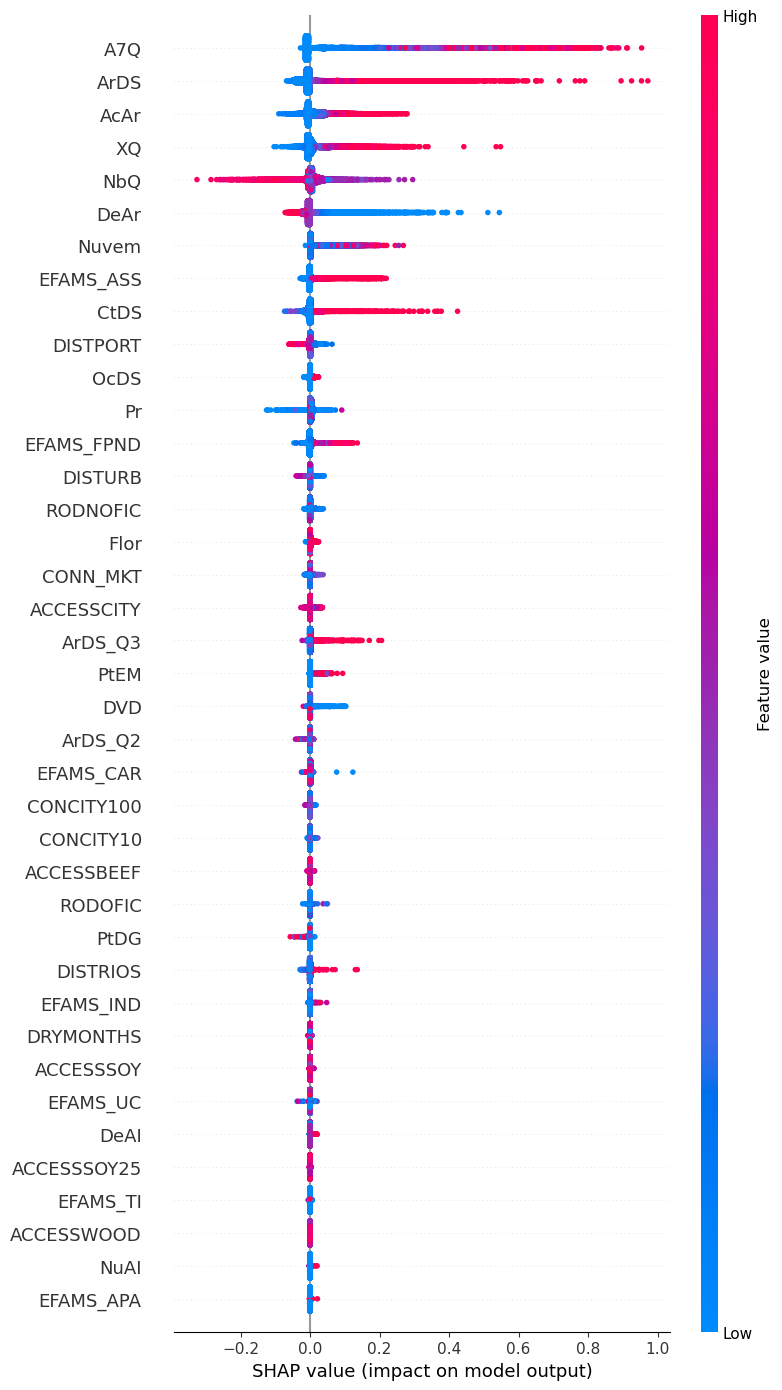

In [36]:
feature_names = args.dynamic.copy()
if args.add_biweek_info:
    feature_names.append('NbQ')
if args.nb_biweek > 1:
    for q in range(args.nb_biweek-1):
        feature_names.append(f'ArDS_Q{q+2}')
if len(args.static) > 0:
    feature_names.extend(args.static)

test_inputs_reshaped_pos = test_inputs_reshaped[test_targets_reshaped>0]
test_inputs_reshaped_neg = test_inputs_reshaped[test_targets_reshaped==0]

index_neg = np.random.choice(test_inputs_reshaped_neg.shape[0], test_inputs_reshaped_pos.shape[0], replace=False) 


explainer = shap.TreeExplainer(best_model,feature_names=feature_names)

stack_test = np.concatenate((test_inputs_reshaped_pos,test_inputs_reshaped_neg[index_neg]))
shap_values = explainer(stack_test)


# Plot feature importance
shap.plots.beeswarm(shap_values, max_display=40, show=False)

# Save the plot as a figure
plt.savefig(os.path.join(args.output_dir, "shap_summary.png"), dpi=100,  bbox_inches='tight')
plt.show()